In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import sklearn
pd.set_option('display.max_columns', 1000)

In [20]:
train = pd.read_csv('Train.csv', sep=',')

In [21]:
train['year'] = train['date'].map(lambda x: x[:4])
train['month'] = train['date'].map(lambda x: abs(int(x[-2:])))

In [22]:
train.head()

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,kw2,kw3,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price,year,month
0,0,2011-1,616,0.0,4,43,2,0,30.0,1.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1738000,2011,1
1,1,2011-1,112,0.0,3,33,1,0,15.0,1.0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,1169000,2011,1
2,2,2011-1,230,NaN,9,34,1,0,25.0,NaN,4,0,1,0,0,0,0,0,0,0,0,0,0,0,2821000,2011,1
3,3,2011-1,302,1.0,4,60,3,0,15.0,0.0,2,1,1,0,0,0,0,0,0,0,0,0,0,0,5714000,2011,1
4,4,2011-1,578,0.0,3,49,2,0,30.0,NaN,2,0,1,0,0,0,0,0,0,0,0,0,0,0,1660000,2011,1


In [23]:
train.shape

(100000, 27)

In [24]:
train['street_id'].nunique()

672

In [25]:
train=train.fillna(train.median())

In [26]:
train['build_tech'] = train['build_tech'].astype(int)

In [27]:
features = ['street_id', 'build_tech', 'floor', 'area', 'rooms',
       'balcon', 'metro_dist', 'g_lift', 'n_photos', 'kw1', 'kw2', 'kw3',
       'kw4', 'kw5', 'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12',
       'kw13', 'year', 'month']

cat_features = ['street_id', 'build_tech']

# Catboost

In [28]:
from catboost import CatBoostRegressor, Pool, cv

In [29]:
def cv_score(n_splits=5, params={'iterations':300,
                                       'learning_rate':0.1,
                                      'subsample':0.8,
                                      'max_depth':5,
                                      'loss_function':'MAE',
                                      'silent':True}):
    kf = KFold(n_splits=5, random_state=None, shuffle=False)
    scores = list()
    for train_index, test_index in kf.split(train[features]):
        X_train, X_test = train.loc[train_index, features], train.loc[test_index, features]
        y_train, y_test = train.loc[train_index, 'price'], train.loc[test_index, 'price']
        model = CatBoostRegressor(**params)
        model = model.fit(X_train, y_train, cat_features=cat_features)
        cur_pred = model.predict(X_test)
        scores.append(mean_absolute_error(y_test, cur_pred))
    return sum(scores)/5

In [30]:
def ct_params_proc():
    params =({'thread_count': 8, 
             'random_seed': 241,
             'loss_function': 'MAE',
              'iterations': 2000,
              'silent': True
             }) 
    
    params_all = [('learning_rate', [0.01, 0.03, 0.05, 0.1, 0.3, 0.5]),
                  ('max_depth',[2,3,4,6,7,9]),
                  ('subsample', [0.7, 0.8, 0.9, 1])
                 ]
    
    result_param =[]
    for i in params_all:
        p= i[0]   
        for param_value in i[1]:      
            params[p] = param_value
            result = []
            cv_res = cv_score(params=params)
            calculated = {'params': p, 'value': param_value, 'mae':cv_res}
            result_param.append (calculated)
            print (calculated)
        r = pd.DataFrame(result_param)

        min_mae = float(r[r.params ==p].mae.min())
        best_param = r[(r.params ==p)&(r.mae == min_mae)].value.iloc[0]
        
        params[p] = best_param

        print(r[r.params ==p])
        print(params)
    
    
        x = r.value[r.params==p]
        ax1= plt.subplot()
        ax1.plot(x, r.mae[r.params==p], color = 'red', label = 'mae')
        ax1.grid()
        ax1.legend(loc='lower right')
        ax1.set_title(p)
        plt.show()
        
    return params, min_mae

{'params': 'learning_rate', 'value': 0.01, 'mae': 783345.0165227407}
{'params': 'learning_rate', 'value': 0.03, 'mae': 684105.6512877446}
{'params': 'learning_rate', 'value': 0.05, 'mae': 656666.2518788715}
{'params': 'learning_rate', 'value': 0.1, 'mae': 638841.2327315675}
{'params': 'learning_rate', 'value': 0.3, 'mae': 646593.6085612217}
{'params': 'learning_rate', 'value': 0.5, 'mae': 672225.4474124466}
          params  value            mae
0  learning_rate   0.01  783345.016523
1  learning_rate   0.03  684105.651288
2  learning_rate   0.05  656666.251879
3  learning_rate   0.10  638841.232732
4  learning_rate   0.30  646593.608561
5  learning_rate   0.50  672225.447412
{'thread_count': 8, 'random_seed': 241, 'loss_function': 'MAE', 'iterations': 2000, 'silent': True, 'learning_rate': 0.1}


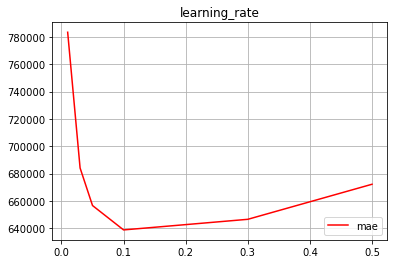

{'params': 'max_depth', 'value': 2, 'mae': 791704.5383758026}
{'params': 'max_depth', 'value': 3, 'mae': 714977.5272519973}
{'params': 'max_depth', 'value': 4, 'mae': 672510.8140402583}
{'params': 'max_depth', 'value': 6, 'mae': 638841.2327315675}
{'params': 'max_depth', 'value': 7, 'mae': 635066.1484030446}
{'params': 'max_depth', 'value': 9, 'mae': 654460.8241915451}
       params  value            mae
6   max_depth    2.0  791704.538376
7   max_depth    3.0  714977.527252
8   max_depth    4.0  672510.814040
9   max_depth    6.0  638841.232732
10  max_depth    7.0  635066.148403
11  max_depth    9.0  654460.824192
{'thread_count': 8, 'random_seed': 241, 'loss_function': 'MAE', 'iterations': 2000, 'silent': True, 'learning_rate': 0.1, 'max_depth': 7.0}


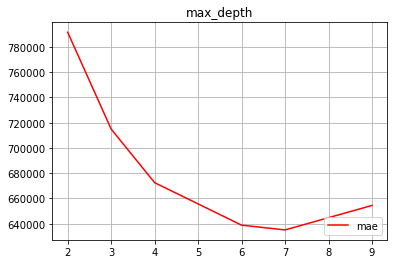

{'params': 'subsample', 'value': 0.7, 'mae': 641768.3112795467}
{'params': 'subsample', 'value': 0.8, 'mae': 635066.1484030446}
{'params': 'subsample', 'value': 0.9, 'mae': 636202.189770394}
{'params': 'subsample', 'value': 1, 'mae': 635988.4004569559}
       params  value            mae
12  subsample    0.7  641768.311280
13  subsample    0.8  635066.148403
14  subsample    0.9  636202.189770
15  subsample    1.0  635988.400457
{'thread_count': 8, 'random_seed': 241, 'loss_function': 'MAE', 'iterations': 2000, 'silent': True, 'learning_rate': 0.1, 'max_depth': 7.0, 'subsample': 0.8}


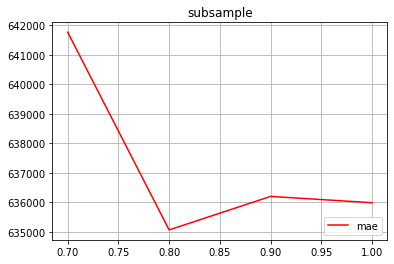

In [31]:
best_params, min_mae = ct_params_proc()

In [32]:
best_params, min_mae

({'thread_count': 8,
  'random_seed': 241,
  'loss_function': 'MAE',
  'iterations': 2000,
  'silent': True,
  'learning_rate': 0.1,
  'max_depth': 7.0,
  'subsample': 0.8},
 635066.1484030446)

# Subm

In [33]:
test = pd.read_csv('Test.csv', sep=',')
test['year'] = test['date'].map(lambda x: x[:4])
test['month'] = test['date'].map(lambda x: abs(int(x[-2:])))
test=test.fillna(test.median())
test['build_tech'] = test['build_tech'].astype(int)
test.head()

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,kw2,kw3,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,year,month
0,100000,2012-3,422,0,1,59,3,0,25.0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2012,3
1,100001,2012-3,380,0,10,58,2,0,25.0,0.0,4,0,1,0,0,0,0,1,0,0,0,0,0,0,2012,3
2,100002,2012-3,362,1,3,54,2,0,10.0,0.0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,2012,3
3,100003,2012-3,34,0,4,35,1,0,25.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2012,3
4,100004,2012-3,562,0,4,56,3,0,30.0,0.0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,2012,3


In [34]:
model = CatBoostRegressor(**best_params)
model = model.fit(train[features], train['price'], cat_features=cat_features)

In [35]:
test['subm_pred'] = model.predict(test[features])

In [36]:
subm = pd.DataFrame(test[['id', 'subm_pred']])
subm.columns = ['id', 'price']
subm.to_csv('last_subm.csv', index=False)